# Seam line example

This notebook provide toy example with seam line or tennis ball curve from the paper

Let's start from some imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.optimize import fsolve
from scipy import linalg
from sklearn.neighbors import NearestNeighbors
from tqdm.notebook import tqdm


import sys
sys.path.append("..")
from quadrics.quadrics_wrapper import Quadrics

%matplotlib inline

Now we will generate data points. Seam line can be described by the following parametrisation
$$
\begin{cases}
x(t) = a \cos(t) + b \cos(3t) \\
y(t) = a \sin(t) - b \sin(3t) \\
z(t) = 2 \sqrt{ab} \sin(2t)
\end{cases}
$$
wher $t \in [0, 2\pi]$. Also we will add some uniform noise.

Outliere point is taken from normal distribution

(-2.5, 2.5)

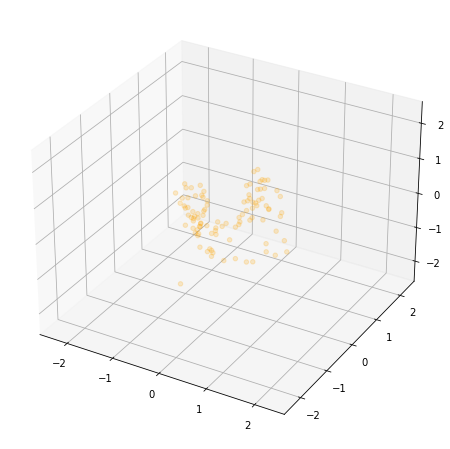

In [5]:
np.random.seed(69)
size, outliers_size = 100, 1
r, p = 1, 0.8
a, b = p*r, (1 - p)*r
t = np.random.uniform(0, 2*np.pi, size)

x_line = a*np.cos(t) + b*np.cos(3*t)
y_line = a*np.sin(t) - b*np.sin(3*t)
z_line = 2*np.sqrt(a*b)*np.sin(2*t)

true_points = np.stack([x_line, y_line, z_line]).T

# noise
noise = np.random.normal(scale=0.12*r, size=(size, 3))
noised_points = true_points + noise

outliers = np.random.normal(scale=1, size=(3, outliers_size))
outliers = 2 * outliers/np.linalg.norm(outliers, axis=0) #+ outliers_n
points = np.vstack([noised_points, outliers.T])
points = np.random.permutation(points)

t_curve = np.linspace(-np.pi, np.pi, 50)
x_curve = a*np.cos(t_curve) + b*np.cos(3*t_curve)
y_curve = a*np.sin(t_curve) - b*np.sin(3*t_curve)
z_curve = 2*np.sqrt(a*b)*np.sin(2*t_curve)

x, y, z = points.T

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, alpha=0.2, c='orange')

scale = 2.5
xmin, xmax, ymin, ymax, zmin, zmax = (-scale, scale)*3

ax.set_zlim3d(zmin,zmax)
ax.set_xlim3d(xmin,xmax)
ax.set_ylim3d(ymin,ymax)

Now we will train our models

We start from kernel PCA

In [6]:
def feature_map(X):
    q = np.einsum('ki,kj->kij',X,X)[(slice(None),) + np.triu_indices(X.shape[-1])]
    return np.hstack((q,X,np.ones((X.shape[0],1))))
def feature_map_q(X):
    return np.einsum('ki,kj->kij',X,X)[(slice(None),) + np.triu_indices(X.shape[-1])]
def projector_q(dim):
    return np.diag(np.hstack((np.ones(dim * (dim + 1) // 2), np.zeros(dim + 1))))

In [7]:
PhiX = feature_map(points)
cov = (PhiX).T.dot(PhiX)
w, v = linalg.eig(cov, b = projector_q(points.shape[1]))
coeffs = v[:,np.argsort(np.real(w))[:2]]

Next we will train quadris using our API

In [8]:
quadrics = Quadrics(n_quadrics=2, dist='dist2_full', device='gpu')
quadrics.fit(points, 500, learning_rate=0.1, batch_size=20)

Epoch  1
Orthonormal error: 0.010124145075678825
Epoch  2
Orthonormal error: 0.008121069520711899
Epoch  3
Orthonormal error: 0.0032183986622840166
Epoch  4
Orthonormal error: 0.0025866786018013954
Epoch  5
Orthonormal error: 0.0015686764381825924
Epoch  6
Orthonormal error: 0.0026061951648443937
Epoch  7
Orthonormal error: 0.005990167148411274
Epoch  8
Orthonormal error: 0.0016159983351826668
Epoch  9
Orthonormal error: 0.01540310587733984
Epoch  10
Orthonormal error: 0.006122644525021315
Epoch  11
Orthonormal error: 0.002752313856035471
Epoch  12
Orthonormal error: 0.003601717296987772
Epoch  13
Orthonormal error: 0.003791936207562685
Epoch  14
Orthonormal error: 0.0019217096269130707
Epoch  15
Orthonormal error: 0.002147455234080553
Epoch  16
Orthonormal error: 0.01657080091536045
Epoch  17
Orthonormal error: 0.0029459367506206036
Epoch  18
Orthonormal error: 0.005802741274237633
Epoch  19
Orthonormal error: 0.0024293619208037853
Epoch  20
Orthonormal error: 0.006069342605769634
Epo

Orthonormal error: 0.013844751752912998
Epoch  166
Orthonormal error: 0.009433010593056679
Epoch  167
Orthonormal error: 0.01205054484307766
Epoch  168
Orthonormal error: 0.008643757551908493
Epoch  169
Orthonormal error: 0.008967127650976181
Epoch  170
Orthonormal error: 0.009580334648489952
Epoch  171
Orthonormal error: 0.009667911566793919
Epoch  172
Orthonormal error: 0.013791481032967567
Epoch  173
Orthonormal error: 0.014620374888181686
Epoch  174
Orthonormal error: 0.01601899415254593
Epoch  175
Orthonormal error: 0.01153851393610239
Epoch  176
Orthonormal error: 0.007596371229737997
Epoch  177
Orthonormal error: 0.013676931150257587
Epoch  178
Orthonormal error: 0.015618054196238518
Epoch  179
Orthonormal error: 0.01526966504752636
Epoch  180
Orthonormal error: 0.011321069672703743
Epoch  181
Orthonormal error: 0.010473494417965412
Epoch  182
Orthonormal error: 0.01382512878626585
Epoch  183
Orthonormal error: 0.008164256811141968
Epoch  184
Orthonormal error: 0.013418283313512

Orthonormal error: 0.017634296789765358
Epoch  331
Orthonormal error: 0.010079970583319664
Epoch  332
Orthonormal error: 0.006732804700732231
Epoch  333
Orthonormal error: 0.010551289655268192
Epoch  334
Orthonormal error: 0.01057583000510931
Epoch  335
Orthonormal error: 0.015053199604153633
Epoch  336
Orthonormal error: 0.014652935788035393
Epoch  337
Orthonormal error: 0.01829047128558159
Epoch  338
Orthonormal error: 0.01448251772671938
Epoch  339
Orthonormal error: 0.015659676864743233
Epoch  340
Orthonormal error: 0.015222862362861633
Epoch  341
Orthonormal error: 0.008113755844533443
Epoch  342
Orthonormal error: 0.007137984968721867
Epoch  343
Orthonormal error: 0.015414007008075714
Epoch  344
Orthonormal error: 0.005993287544697523
Epoch  345
Orthonormal error: 0.005944595206528902
Epoch  346
Orthonormal error: 0.0110940495505929
Epoch  347
Orthonormal error: 0.006238012574613094
Epoch  348
Orthonormal error: 0.00809759646654129
Epoch  349
Orthonormal error: 0.0095115127041935

Orthonormal error: 0.017486903816461563
Epoch  496
Orthonormal error: 0.01221776194870472
Epoch  497
Orthonormal error: 0.014502245001494884
Epoch  498
Orthonormal error: 0.014341595582664013
Epoch  499
Orthonormal error: 0.017072763293981552
Epoch  500
Orthonormal error: 0.010337268933653831


Now we will add some stuff for ploting implicit lines

In [9]:
from graph_utils import GridSolver, get_points_line

Let's build line blocks for quadrics

In [10]:
x = np.linspace(-2, 2, num=10)
y = np.linspace(-2, 2, num=10)
grid = np.array(np.meshgrid(x, y)).reshape((2, -1)).T
z = np.linspace(-4, 4, num=100)

q_points = []
for z_0 in tqdm(z):
    def equations(p):
        x, y = p
        p_0 = np.array([x, y, z_0])
        return quadrics.get_distances(p_0, dist='dist0')
    gs = GridSolver(equations, grid)
    sols = gs.find()
    for p in sols:
        x, y = p
        q_points.append((x, y, z_0))

quad_bloks = get_points_line(np.array(q_points))

  0%|          | 0/100 [00:00<?, ?it/s]

And for kPCA

In [11]:
def get_coeff_matrix(coeffs, ndim):
    quadratic = coeffs[:ndim*(ndim + 1)//2]
    linear = coeffs[ndim*(ndim + 1)//2:-1]
    free = coeffs[-1]
    M = np.zeros((ndim + 1, ndim + 1))
    M[np.triu_indices(3)] = quadratic
    M[np.tril_indices(3)] = M.T[np.tril_indices(3)]
    M[ndim, :ndim] = linear
    M[:ndim, ndim] = linear
    M[ndim, ndim] = free
    return M

def quadric_value(coeffs, point):
    point1 = np.append(point,1)  
    return point1.T.dot(coeffs.dot(point1))

In [12]:
x = np.linspace(-2, 2, num=10)
y = np.linspace(-2, 2, num=10)
grid = np.array(np.meshgrid(x, y)).reshape((2, -1)).T
z = np.linspace(-2, 2, num=100)

q_points = []
for z_0 in tqdm(z):
    def equations(p):
        x, y = p
        p_0 = np.array([x, y, z_0])
        #return quadrics.get_distances(p_0, dist='dist0')
        return [quadric_value(get_coeff_matrix(coeffs[:, 0], 3),p_0),quadric_value(get_coeff_matrix(coeffs[:, 1], 3),p_0)]
    gs = GridSolver(equations, grid)
    sols = gs.find()
    for p in sols:
        x, y = p
        q_points.append((x, y, z_0))
        
kpca_bloks = get_points_line(np.array(q_points))

  0%|          | 0/100 [00:00<?, ?it/s]

Let's plot the final picture

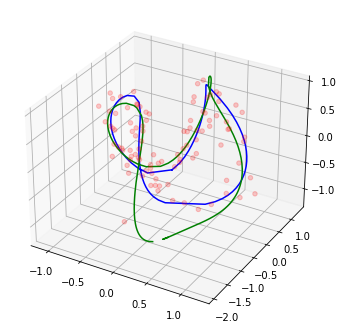

In [13]:
fig = plt.figure(figsize=(4, 4))
fig.subplots_adjust(left=-0.05, right=1.05, bottom=-0.5, top=1.5)
ax = fig.add_subplot(111, projection='3d')

x, y, z = points.T
ax.scatter(x, y, z, alpha=0.2, c='red')

# dist2 solution
for block in quad_bloks:
    ax.plot(block[:,0], block[:,1], block[:, 2], c = 'blue')
    
for block in kpca_bloks:
    ax.plot(block[:,0], block[:,1], block[:, 2], c = 'green')    